<a href="https://colab.research.google.com/github/valenciajaime/MN2022_colabs/blob/main/Prueba_Electrodo_02_rev01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portada Presentación Clase

**Nombres:** 

Esteban Velilla H.

Jaime A. Valencia V.


**Email:**

esteban.velilla@udea.edu.co

jalejandro.valencia@udea.edu.co


**Curso:**
Métodos numéricos 2022-1

**Fecha:**
Jueves 2022-dic-01

# Descripción

**Objetivos**

PRUEBA CON DATOS DIGITALIZADOS DE HIDROCOL
2022-NOV-22


Presentación de la metodologia de ajuste de parametros en una ecuacion diferencial ordinario. 
papar Grcev_2005  fig. 1(c).

Se usa la funcion minimize() de scipy.optimization para ajustar parametros


**Desarrollo**



1.   Solucion de EDO usando odeint()
2.   Programacion funcion de Error
3.   Optimizacion de parametros



La imagen muestra la metodologia a seguir para realizar el ajuste de parametros.
Para este caso el ajuste es de 4 parametros (RT,LT,CT) y asumimos fuente de corriente.

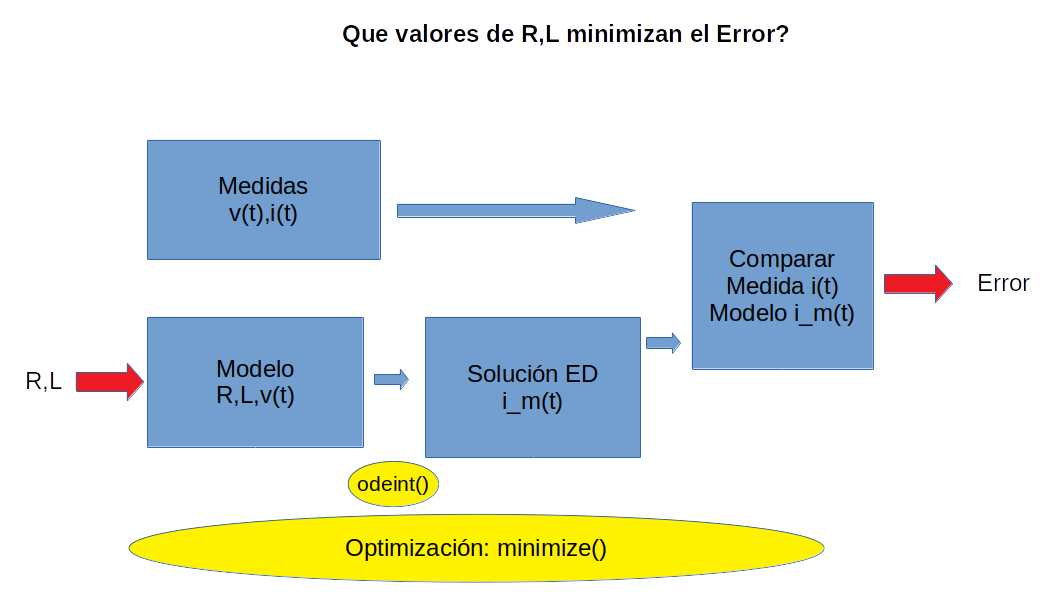

# Modulos principales

Importacion de modulo principales de trabajo en Metodos Numericos.

In [ ]:
import pylab as plt
import matplotlib
import numpy as np
import scipy as SC
import sympy as SP

Observacion de las versiones de los modulos importados.

In [ ]:
print("Version numpy: ",np.__version__)
print("Version Matplotlib: ",matplotlib.__version__)
print("Version scipy: ", SC.__version__)
print("Version sympy: ",  SP.__version__)

Version numpy:  1.21.6
Version Matplotlib:  3.2.2
Version scipy:  1.4.1
Version sympy:  1.7.1


# Solucion de EDO usando odeint()

## programacion funcion ode

In [ ]:
import  matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint #funcion para solucion EDO

##funcion de la ecuacion diferencia
#base circuito IEC R1 serie (RT-LT, paralelo CT)
##NUEVO BASE CIRCUITO GRECV LT serie(RT paralelo CT)
def RLCmalla(Z, t, RT = 23, LT = 0.1, CT = 1e-6, Fv= lambda x:11.0 ):
    """Z: funcion vectorial dependiente de t
       t: variable independiente
       Funcion para solucion del circuito
       
       di_t/dt = (Fv - vc)/LT 
       d vc/dt = (i_t/c) - (vc/CT*RT)
       Z = [i_t, vc]
       
    """
    # voltaje en voltios
    # RT en ohmios
    # LT en Henrios
    # CT en Faradios

    Vf = Fv(t) ##evaluacion de la funcion 
     
    i_t = Z[0] #corriente del circuito
    Vc = Z[1] #voltaje en condensador
    di_t = (1/LT)*(Vf - Vc)
    dvc = (i_t/CT) - (Vc/(CT*RT))
    return [di_t, dvc]



## Solucion EDO

In [ ]:
#Definir parametros
R=23
L=0.001
C=1e-6
F_in = lambda x:11.2

#definir condicion inicial
Io = 0.0
Vco= 0.0
print('Corriente, Vc inicial (cir): ', Io,Vco)

##definir rango de solucion

t_inicial = 0
t_final= 0.0007
T = np.linspace(t_inicial, t_final, 200)

print('Solucion entre ',t_inicial,' y ',t_final, 'segundos')

##Solucionar la ED
y_sol = odeint(RLCmalla, [Io,Vco], T,(R,L,C, F_in))##f(i,t),Condic inic, tiempo,argumetos




Corriente, Vc inicial (cir):  0.0 0.0
Solucion entre  0  y  0.0007 segundos


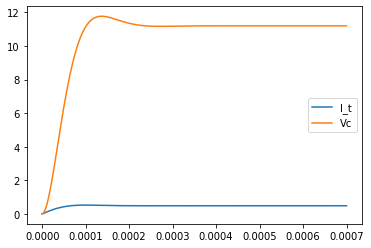

In [ ]:
##gRAFICO SOLUCION
plt.plot(T,y_sol[:,0],T,y_sol[:,1])
plt.legend(["I_t","Vc"])

# Lectura de datos(2022-nov-16)

In [ ]:
##Lectura de datos
#Lectura de datos de entrada de la simulacion en funcion del tiempo

V_datos = np.genfromtxt("V_22nov_med_6.csv", delimiter=";")
I_datos = np.genfromtxt("I_22nov_med_6.csv", delimiter=";")

Se crea objeto E2 de la clase MElectrodoT01()


#Grafico (Datos leidos)

Numero datos:  64


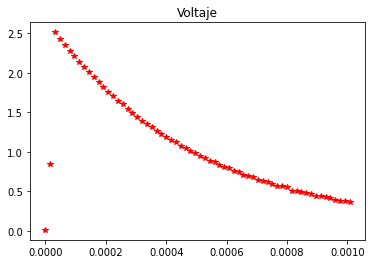

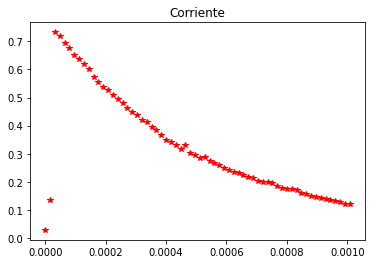

In [ ]:
##REEMPLAZO DE DATOS#######
##observacion
STEP = 1000 ##recote de datos para ajuste mas rapido

T = V_datos[::STEP,0]
y_volt = V_datos[::STEP,1]
y_cur= I_datos[::STEP,1]

print("Numero datos: ",len(T))
plt.figure(1)
plt.plot(T,y_volt,"r*")
plt.title("Voltaje")
plt.show()

plt.figure(2)
plt.plot(T, y_cur,"r*")
plt.title("Corriente")
plt.show()


# Problema de optimizacion

Paso1. Crear funcion de error.

Paso2. Minimizar la funcion de error.


Caso sin restriccion
[minimize()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

## Programacion funcion Error

In [ ]:
##funcion Error que calcula la diferencia
## entre los datos y el modelo
## variable :RT, LT, CT
## datos entrada: v(t), i(t)
## Calculo: error cuadratico promedio

def F_error_edo03(X, D_tiempo, D_voltios, D_amps):
    """X = [RT,LT,CT] en Ohms y Henrios
       D_tiempo: lista de instantes de tiempo
       D_voltios: Lista de valores de voltaje(t) medidos
       D_amps: Lista de valores de corriente(t) medidos.
       La funcion calcula el error cuadratico medio entre
       el resultado de la solucion de la ecuacion diferencia
       con los parametros R, L , C y los respectivos valores 
       de la corriente medidos.
    """
    R_in, L_in, C_in = X #parametros del circuito que entran
    Io = 0.0 # se asume el primer dato del vector de corriente 
    Vco = 0.0         ###asumido      #  medido
    V_fuente = lambda xx: np.interp(xx,D_tiempo,D_voltios)

    S_modelo = odeint(RLCmalla, [Io,Vco], D_tiempo,(R_in,L_in,C_in, V_fuente))#Solucion EDO
    I_t = S_modelo[:,0]
    ##calculo del voltaje a la entrada en modelo
    Suma=0
    NN = len(S_modelo)
    for q in range(NN):
        ei = (I_t[q]- D_amps[q])**2
        Suma = Suma + ei
    error = Suma/NN## suma error cuadratico medio
    
    return error


In [ ]:
#Evaluando la funcion de error
X0 = [1 ,0.01,1e-6]##Datos: RT, LT, CT
F_error_edo03(X0, T, y_volt, y_cur)

0.10918232153382275

## Comparacion grafica

In [ ]:
##funcion Error que calcula la diferencia
## entre los datos y el modelo
## variable : R, L y C
## datos entrada: v(t), i(t)
## Calculo: error cuadratico promedio

def F_Show_error_edo03(X, D_tiempo, D_voltios, D_amps):
    """X = [RT,LT,CT] en Ohms y Henrios
       D_tiempo: lista de instantes de tiempo
       D_voltios: Lista de valores de voltaje(t) medidos
       D_amps: Lista de valores de corriente(t) medidos.
       La funcion calcula el error cuadratico medio entre
       el resultado de la solucion de la ecuacion diferencia
       con los parametros R, L, C y los respectivos valores 
       de la corriente medidos.
    """
    R_in, L_in, C_in = X #parametros del circuito que entran
    Io = 0.0 # se asume el primer dato del vector de corriente 
    Vco = 0.0         ###asumido      #  medido
    V_fuente = lambda xx: np.interp(xx,D_tiempo,D_voltios)

    S_modelo = odeint(RLCmalla, [Io,Vco], D_tiempo,(R_in,L_in,C_in, V_fuente))#Solucion EDO
    I_t = S_modelo[:,0]
    ##calculo del voltaje a la entrada en modelo
    Suma=0
    NN = len(S_modelo)
    for q in range(NN):
        ei = (I_t[q]- D_amps[q])**2
        Suma = Suma + ei
    error = Suma/NN## suma error cuadratico medio
        
    print("Error Cuadratico Medio= ",error)
    plt.plot(D_tiempo,D_amps,"ro")
    plt.plot(D_tiempo, I_t,"b*-")
    plt.legend(["Datos","Modelo"])
    plt.show()
    return error


Error Cuadratico Medio=  0.00045327548806654914


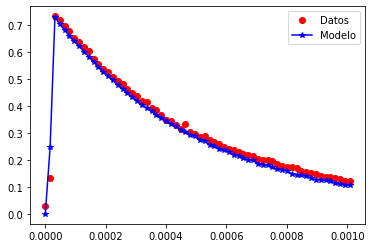

0.00045327548806654914

In [ ]:
X1 = [3.45 ,0.000001,.1e-6]
F_Show_error_edo03(X1, T, y_volt, y_cur)

##Funcion minimize

In [ ]:
from scipy.optimize import minimize

## aplicando un funcion de optimizacion
X0 = [3.45 ,0.000001,.1e-6]#vector inicial de busqueda

##Cotas RT, LT, CT
Lim_low = 1e-10
bnds = ((Lim_low, 100), (Lim_low,1), (Lim_low,1))

res = minimize(F_error_edo03,X0,args=(T, y_volt, y_cur),
               method='Nelder-Mead',bounds=bnds, tol=1e-5)#method="Powell"),


print("Valores RT,LT,CT: ",res.x)
print("Error minimo: ",res.fun)



Valores RT,LT,CT:  [3.33812512e+00 6.87686884e-06 1.00000000e-10]
Error minimo:  0.00024117180894570934


Error Cuadratico Medio=  0.00024117180894570934


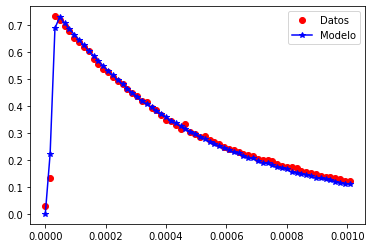

0.00024117180894570934

In [ ]:
##Validacion resultados

F_Show_error_edo03(res.x, T, y_volt, y_cur)

# Resultados y conclusiones

**Conclusiones:**

Buen resultado para la respuesta al impulso.
Caso de medidas realizadas 22 de noviembre en cancha UdeA.



**Resultados:**


**Referencias:**



*Libros*

[Numerical Computing with MATLAB
Copyright 2004, Cleve Moler. Introd.](https://www.mathworks.com/content/dam/mathworks/mathworks-dot-com/moler/intro.pdf)

[Burde & Faires](https://udeaeduco.sharepoint.com/:b:/s/MtodosNumricos_2022-1/EQd1_32TgMhCh8MBU0FqxpIBSIjxSMEJKAcVIVyvYZHSng?e=nrWw8z)

[Chapra & Canale](https://udeaeduco.sharepoint.com/:b:/s/MtodosNumricos_2022-1/EZgs5MpMDKtLpAZlwGEmn9oB3FvpAGncvlnWPcZ9wRNhIg?e=fPcsyf)





[scipy-interpolate 1.8.1](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html#)  [1.4.1](https://docs.scipy.org/doc/scipy-1.4.1/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)

[2017-marzo-15 Prezi](http://numericalmethodsie20152udea.blogspot.com/2017/03/interpolacion-ajuste-y-procesamieto-de.html)

[Guia Burden y Chapra](http://numericalmethodsie20152udea.blogspot.com/2017/03/documentacion-interpolacion-y-ajuste.html)

[2016-sep-14](http://numericalmethodsie20152udea.blogspot.com/2016/09/ajuste-de-funcion-no-lineal.html)

[2016-sep-7](http://numericalmethodsie20152udea.blogspot.com/2016/09/interpolacion-y-ajuste-de-datos.html)